In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.utils import np_utils
from keras.models import load_model

from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from pathlib import Path
import os.path
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
'''import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Dataset.zip','r')
zip_ref.extractall('/content/drive/MyDrive')
zip_ref.close()'''


In [ ]:
image_dir = Path('/content/drive/MyDrive/Dataset')

In [ ]:
filepaths = list(image_dir.glob(r'**/*.jpg'))

In [ ]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [ ]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
images = pd.concat([filepaths,labels], axis=1)

In [ ]:
labels.value_counts()

Healthy      2981
Corrosion    2807
Cracks       2537
Name: Label, dtype: int64

In [ ]:
X, Y = train_test_split(images, train_size=0.7, shuffle=True, random_state=1)

In [ ]:
import tensorflow as tf

# Define ImageDataGenerator for training data with augmentation
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input,  # Using ResNet-50 preprocessing
    validation_split=0.2  # This indicates the split ratio for validation
)

# Define ImageDataGenerator for testing data with the same augmentation
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input  # Using ResNet-50 preprocessing
)


In [ ]:
train_images = train_generator.flow_from_dataframe(dataframe = X, x_col='Filepath', y_col='Label',
                                    target_size = (224,224), color_mode='rgb',
                                    class_mode='categorical', batch_size=32, shuffle=True,
                                                   seed=42, subset='training')

val_images = train_generator.flow_from_dataframe(dataframe = X, x_col='Filepath', y_col='Label',
                                    target_size = (224,224), color_mode='rgb',
                                    class_mode='categorical', batch_size=32, shuffle=True,
                                                   seed=42, subset='validation')

test_images = test_generator.flow_from_dataframe(dataframe = Y, x_col='Filepath', y_col='Label',
                                    target_size = (224,224), color_mode='rgb',
                                    class_mode='categorical', batch_size=32, shuffle=False)

Found 4662 validated image filenames belonging to 3 classes.
Found 1165 validated image filenames belonging to 3 classes.
Found 2498 validated image filenames belonging to 3 classes.


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
mc = ModelCheckpoint (filepath= "./best_model1.h5",monitor="val_acc",verbose=1,save_best_only= True)
es = EarlyStopping (monitor= "val_acc",min_delta= 0.01,patience= 5,verbose= 1)
cb = [mc, es]

In [ ]:
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3),pooling='avg',classes=3)
for layer in conv_base.layers:
        layer.trainable=False

In [ ]:
model = models.Sequential()

model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(45, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(9, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(3, activation='softmax'))






In [ ]:

model.compile('adam',
    loss='categorical_crossentropy',
    metrics=['acc'])
model.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_11 (Flatten)        (None, 2048)              0         
                                                                 
 batch_normalization_21 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense_25 (Dense)            (None, 45)                92205     
                                                                 
 dropout_14 (Dropout)        (None, 45)                0         
                                                                 
 batch_normalization_22 (Bat  (None, 45)               180       
 chNormalization)                                    

In [ ]:
hist = model.fit(train_images, epochs=50, validation_data=val_images ,batch_size= 32, callbacks=[cb] )

Epoch 1/50
146/146 [==============================] - ETA: 0s - loss: 1.0005 - acc: 0.5487
Epoch 1: val_acc improved from -inf to 0.55193, saving model to ./best_model1.h5
146/146 [==============================] - 107s 633ms/step - loss: 1.0005 - acc: 0.5487 - val_loss: 0.9917 - val_acc: 0.5519
Epoch 2/50
146/146 [==============================] - ETA: 0s - loss: 0.7966 - acc: 0.6662
Epoch 2: val_acc improved from 0.55193 to 0.60944, saving model to ./best_model1.h5
146/146 [==============================] - 91s 623ms/step - loss: 0.7966 - acc: 0.6662 - val_loss: 0.9231 - val_acc: 0.6094
Epoch 3/50
146/146 [==============================] - ETA: 0s - loss: 0.7397 - acc: 0.7023
Epoch 3: val_acc improved from 0.60944 to 0.72618, saving model to ./best_model1.h5
146/146 [==============================] - 91s 620ms/step - loss: 0.7397 - acc: 0.7023 - val_loss: 0.7400 - val_acc: 0.7262
Epoch 4/50
146/146 [==============================] - ETA: 0s - loss: 0.6733 - acc: 0.7357
Epoch 4: val_a

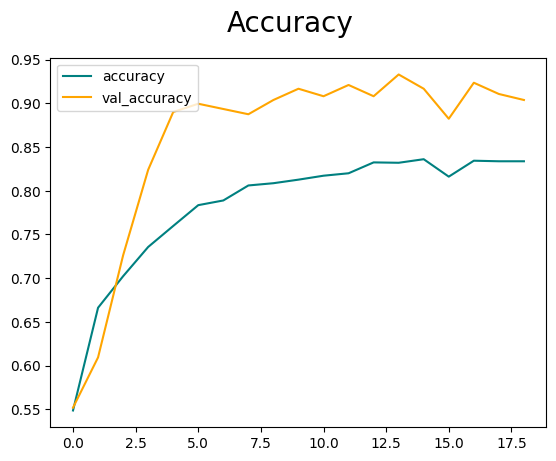

In [ ]:
#plotting accuracy
fig = plt.figure()
plt.plot(hist.history['acc'], color='teal', label='accuracy')
plt.plot(hist.history['val_acc'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

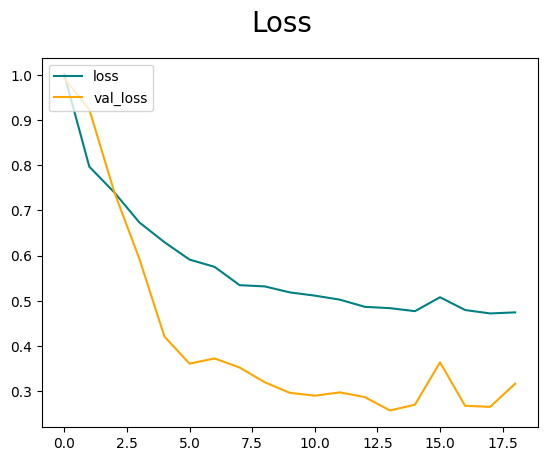

In [ ]:
#plotting loss
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
results = model.evaluate(test_images, verbose=1)
print('Test Accuracy: {:.2f}%'.format(results[1]*100))

79/79 [==============================] - 41s 506ms/step - loss: 0.2895 - acc: 0.9191
Test Accuracy: 91.91%


In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
predictions = np.argmax(model.predict(test_images),axis=1)
cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices)

79/79 [==============================] - 49s 603ms/step


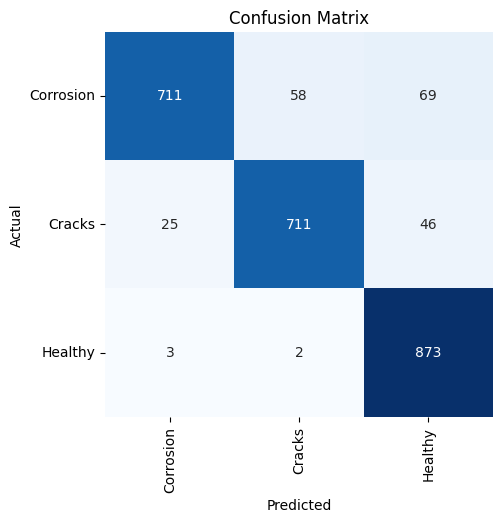

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar = False)
plt.xticks(ticks=np.arange(3)+0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(3)+0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print('Classification Report:\n----------------------\n', clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

   Corrosion       0.96      0.85      0.90       838
      Cracks       0.92      0.91      0.92       782
     Healthy       0.88      0.99      0.94       878

    accuracy                           0.92      2498
   macro avg       0.92      0.92      0.92      2498
weighted avg       0.92      0.92      0.92      2498

